In [40]:

from matplotlib import pyplot as plt
import gdal
from sklearn import cluster
from skimage import exposure
import numpy as np

file_path = r'.\data\image\crop_p224r63_all_bands_29192.tif'
#img = gdal.Open(r'C:\Users\rss_prakti1\multi-spectral_image_classification\data\image\crop_p224r63_all_bands_29192.tif')
#data = img.ReadAsArray()
bands_data, n_bands, geo_transform, proj  = raster_to_npndarray(file_path, str_clip=2)
img = np.dstack([img[:, :, 2], img[:, :, 1], img[:, :, 0]]) # bands_data
data = img# .ReadAsArray()
X = data.reshape((-1,1))

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)
X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(data.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
# rgb_img = np.dstack([img[:, :, 2], img[:, :, 1], img[:, :, 0]])
# X_cluster_img = np.dstack([X_cluster[:, :, 3], X_cluster[:, :, 1], X_cluster[:, :, 0]])
ax1.imshow(data)
ax2.imshow(X_cluster, cmap="hsv")

img = gdal.Open(r'C:\Users\rss_prakti1\multi-spectral_image_classification\data\image\crop_p224r63_all_bands_29192.tif')
data = img.ReadAsArray()
x = np.array([1, 2, 3, -1, 5])

In [67]:
import logging
import os

import xarray as xr
import xgeo # Needs to be imported to use geo extension

# from docopt import docopt
from osgeo import gdal
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from pathlib import Path




logger = logging.getLogger(__name__)

# A list of "random" colors
COLORS = [
    "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
    "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
    "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
    "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"
]


def create_mask_from_vector(vector_data_path, cols, rows, geo_transform, projection, target_value=1,
                            output_fname='', dataset_format='MEM'):
    """
    Rasterize the given vector (wrapper for gdal.RasterizeLayer). Return a gdal.Dataset.
    :param vector_data_path: Path to a shapefile
    :param cols: Number of columns of the result
    :param rows: Number of rows of the result
    :param geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.
    :param projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    :param target_value: Pixel value for the pixels. Must be a valid gdal.GDT_UInt16 value.
    :param output_fname: If the dataset_format is GeoTIFF, this is the output file name
    :param dataset_format: The gdal.Dataset driver name. [default: MEM]
    """
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    if data_source is None:
        report_and_exit("File read failed: %s", vector_data_path)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName(dataset_format)
    target_ds = driver.Create(output_fname, cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """
    Rasterize, in a single image, all the vectors in the given directory.
    The data of each file will be assigned the same pixel value. This value is defined by the order
    of the file in file_paths, starting with 1: so the points/poligons/etc in the same file will be
    marked as 1, those in the second file will be 2, and so on.
    :param file_paths: Path to a directory with shapefiles
    :param rows: Number of rows of the result
    :param cols: Number of columns of the result
    :param geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.
    :param projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    """
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        logger.debug("Processing file %s: label (pixel value) %i", path, label)
        ds = create_mask_from_vector(path, cols, rows, geo_transform, projection,
                                     target_value=label)
        band = ds.GetRasterBand(1)
        a = band.ReadAsArray()
        logger.debug("Labeled pixels: %i", len(a.nonzero()[0]))
        labeled_pixels += a
        ds = None
    return labeled_pixels


def write_geotiff(fname, classes, data, geo_transform, projection, data_type=gdal.GDT_Byte):
    """
    Create a GeoTIFF file with the given data.
    :param fname: Path to a directory with shapefiles
    :param data: Number of rows of the result
    :param geo_transform: Returned value of gdal.Dataset.GetGeoTransform (coefficients for
                          transforming between pixel/line (P,L) raster space, and projection
                          coordinates (Xp,Yp) space.
    :param projection: Projection definition string (Returned by gdal.Dataset.GetProjectionRef)
    """
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, data_type)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    # print(len(np.unique(data, return_inverse=True)))
    band.WriteArray(data)

    ct = gdal.ColorTable()
    for pixel_value in range(len(classes)+1):
        color_hex = COLORS[pixel_value]
        r = int(color_hex[1:3], 16)
        g = int(color_hex[3:5], 16)
        b = int(color_hex[5:7], 16)
        ct.SetColorEntry(pixel_value, (r, g, b, 255))
    band.SetColorTable(ct)

    metadata = {
        'TIFFTAG_COPYRIGHT': 'CC BY 4.0',
        'TIFFTAG_DOCUMENTNAME': 'classification',
        'TIFFTAG_IMAGEDESCRIPTION': 'Supervised classification.',
        'TIFFTAG_MAXSAMPLEVALUE': str(len(classes)),
        'TIFFTAG_MINSAMPLEVALUE': '0',
        'TIFFTAG_SOFTWARE': 'Python, GDAL, scikit-learn'
    }
    dataset.SetMetadata(metadata)

    dataset = None  # Close the file
    return


def report_and_exit(txt, *args, **kwargs):
    logger.error(txt, *args, **kwargs)
    exit(1)
    
'''
opts = docopt(__doc__)

validation_data_path = opts['--validation'] if opts['--validation'] else None
log_level = logging.DEBUG if opts["--verbose"] else logging.INFO
method = opts["--method"]

logging.basicConfig(level=log_level, format='%(asctime)-15s\t %(message)s')
gdal.UseExceptions()

logger.debug("Reading the input: %s", raster_data_path).
'''
def classic_classifier(method, raster_data_path, train_data_path, validation_data_path, output_fname):
    try:
        raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
    except RuntimeError as e:
        report_and_exit(str(e))

    geo_transform = raster_dataset.GetGeoTransform()
    proj = raster_dataset.GetProjectionRef()
    bands_data = []
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())

    bands_data = np.dstack(bands_data)
    rows, cols, n_bands = bands_data.shape
    # A sample is a vector with all the bands data. Each pixel (independent of its position) is a
    # sample.
    n_samples = rows*cols

    logger.debug("Process the training data")
    try:
        files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
        # print(files)
        classes = [f.split('.')[0] for f in files]
        shapefiles = [os.path.join(train_data_path, f) for f in files if f.endswith('.shp')]
    except OSError.FileNotFoundError as e:
        report_and_exit(str(e))

    labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
    is_train = np.nonzero(labeled_pixels)
    training_labels = labeled_pixels[is_train]
    training_samples = bands_data[is_train]

    flat_pixels = bands_data.reshape((n_samples, n_bands))

    #
    # Perform classification
    #
    CLASSIFIERS = {
        # http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        'random-forest': RandomForestClassifier(n_jobs=4, n_estimators=10, class_weight='balanced'),
        # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
        'svm': SVC(class_weight='balanced'),
        'linear-svm': SVC(kernel="linear", C=0.025),
        'svm-gamma': SVC(gamma=2, C=1),
        'nearest-neighbors': KNeighborsClassifier(3),
        'Gaussian-Process': GaussianProcessClassifier(1.0 * RBF(1.0)),
        'Decision-Tree': DecisionTreeClassifier(max_depth=5),
        'random-forest-1feature': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        'Neural-Net': MLPClassifier(alpha=1, max_iter=1000),
        'AdaBoost': AdaBoostClassifier(),
        'Naive-Bayes': GaussianNB(),
        'Quad-Discr': QuadraticDiscriminantAnalysis()
    }

    classifier = CLASSIFIERS[method]
    logger.debug("Train the classifier: %s", str(classifier))
    classifier.fit(training_samples, training_labels)

    logger.debug("Classifing...")
    result = classifier.predict(flat_pixels)

    # Reshape the result: split the labeled pixels into rows to create an image
    classification = result.reshape((rows, cols))
    write_geotiff(output_fname, classes, classification, geo_transform, proj)
    logger.info("Classification created: %s", output_fname)

    #
    # Validate the results
    #
    if validation_data_path:
        logger.debug("Process the verification (testing) data")
        try:
            shapefiles = [os.path.join(validation_data_path, "%s.shp" % c) for c in classes]
        except OSError.FileNotFoundError as e:
            report_and_exit(str(e))

        verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
        for_verification = np.nonzero(verification_pixels)
        verification_labels = verification_pixels[for_verification]
        predicted_labels = classification[for_verification]

        logger.info("Confussion matrix:\n%s", str(
            metrics.confusion_matrix(verification_labels, predicted_labels)))
        target_names = ['Class %s' % s for s in classes]
        logger.info("Classification report:\n%s",
                    metrics.classification_report(verification_labels, predicted_labels,
                                                  target_names=target_names))
        logger.info("Classification accuracy: %f",
                    metrics.accuracy_score(verification_labels, predicted_labels))
        return verification_labels, predicted_labels


In [92]:
# BASE_DIR = Path(__file__).resolve().parent.parent
BASE_DIR = Path().resolve()
Prj_Path = BASE_DIR.joinpath('./')# os.path.join(Shared, './rss_general_classifier/rss_general_classifier')
print(Prj_Path)

/home/jovyan/shared/Islam/rss_general_classifier/rss_general_classifier


In [93]:
# Prj_Path = os.chdir(os.path.join(Shared, './rss_general_classifier/rss_general_classifier')
file_path = Prj_Path.joinpath('./data/image/crop_p224r63_all_bands_29192.tif')
raster_data_path = Prj_Path.joinpath("./data/image/crop_p224r63_all_bands_29192.tif")
train_data_path = Prj_Path.joinpath('./data/test/classes')
output_fname = Prj_Path.joinpath('./data/image/crop_p224r63_all_bands_29192.tif')
method = 'random-forest'
validation_data_path = Prj_Path.joinpath('./data/train/classes')

classifier_names = [
    'random-forest',
    'svm',
    'linear-svm',
    'svm-gamma' ,
    'nearest-neighbors' ,
    #'Gaussian-Process' ,
    'Decision-Tree',
    'random-forest-1feature',
    'Neural-Net',
    'AdaBoost',
    'Naive-Bayes' ,
    'Quad-Discr'
]

classifier_names = [
    # http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    'random-forest',
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    'svm',
    'cart'
]

In [94]:
raster_data_path = Prj_Path.joinpath('./data/image/crop_p224r63_all_bands_29192.tif') # os.path.join(Prj_Path, file_path)
print(raster_data_path)

/home/jovyan/shared/Islam/rss_general_classifier/rss_general_classifier/data/image/crop_p224r63_all_bands_29192.tif


In [99]:
ds = xr.open_rasterio(raster_data_path)
dset= ds.to_dataset(name='image')
print(ds)
dset.geo.stats()

train_data_file = Prj_Path.joinpath('./data/train/train_data_29192.shp')
print(train_data_file)
dset.geo.sample(vector_file=str(train_data_file), value_name='id')


<xarray.DataArray (band: 5, y: 1170, x: 2212)>
[12940200 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5
  * y        (y) float64 9.562e+06 9.562e+06 9.562e+06 ... 9.529e+06 9.529e+06
  * x        (x) float64 5.942e+05 5.942e+05 5.943e+05 ... 6.572e+05 6.572e+05
Attributes:
    transform:   (28.49991227626653, 0.0, 594202.6568389062, 0.0, -28.4999122...
    crs:         +init=epsg:29192
    res:         (28.49991227626653, 28.49991227626653)
    is_tiled:    0
    nodatavals:  (-3.4e+38, -3.4e+38, -3.4e+38, -3.4e+38, -3.4e+38)
/home/jovyan/shared/Islam/rss_general_classifier/rss_general_classifier/data/train/train_data_29192.shp


CRSError: Invalid projection: +init=epsg:29192 +type=crs: (Internal Proj Error: proj_create: cannot expand +init=epsg:29192 +type=crs)

In [96]:
vector_file=os.path.join(Prj_Path, r'./data/train/classes/train_data_29192.shp')
dset.geo.zonal_stats(vector_file)

DriverError: /home/jovyan/shared/Islam/rss_general_classifier/rss_general_classifier/./data/train/classes/train_data_29192.shp: No such file or directory

/home/jovyan/shared/Islam/./rss_general_classifier/rss_general_classifier


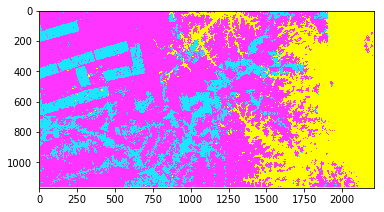

In [18]:
print(Prj_Path)

image = plt.imread(output_fname)
plt.imshow(image)

In [19]:
verification_labels, predicted_labels = classic_classifier(classifier_names[0], raster_data_path, train_data_path, validation_data_path, output_fname)

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [20]:
i = 1
output_image = output_fname[:-4] + '_' + str('%02d' % i) + '_' + classifier_names[i] +  output_fname[-4:] 
print(output_image)
print('%02d' % i)

/home/jovyan/shared/Islam/./rss_general_classifier/rss_general_classifier/./data/image/crop_p224r63_all_bands_29192_train_01_svm.tif
01


In [21]:
for i in range(len(classifier_names)):
    print('Classifier Method:' + classifier_names[i], '\n')
    output_image = output_fname[:-4] + '_' + str('%02d' % i) + '_' + classifier_names[i] +  output_fname[-4:] 
    verification_labels, predicted_labels = classic_classifier(classifier_names[i], raster_data_path, train_data_path, validation_data_path, output_image)

    print("Confussion matrix:\n", str(
                metrics.confusion_matrix(verification_labels, predicted_labels)))

    print("Classification report:\n",
                        metrics.classification_report(verification_labels, predicted_labels,
                                                      ))
    print("Classification accuracy: ",
                metrics.accuracy_score(verification_labels, predicted_labels))

Classifier Method:random-forest 



/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Confussion matrix:
 [[ 4641     0     0]
 [    0 10330    63]
 [    0     6 14292]]
Classification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      4641
         2.0       1.00      0.99      1.00     10393
         3.0       1.00      1.00      1.00     14298

   micro avg       1.00      1.00      1.00     29332
   macro avg       1.00      1.00      1.00     29332
weighted avg       1.00      1.00      1.00     29332

Classification accuracy:  0.9976476203463793
Classifier Method:svm 



/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Confussion matrix:
 [[ 4614    27     0]
 [    0 10390     3]
 [    0   316 13982]]
Classification report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      1.00      4641
         2.0       0.97      1.00      0.98     10393
         3.0       1.00      0.98      0.99     14298

   micro avg       0.99      0.99      0.99     29332
   macro avg       0.99      0.99      0.99     29332
weighted avg       0.99      0.99      0.99     29332

Classification accuracy:  0.9882040092731488
Classifier Method:cart 



KeyError: 'cart'

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
     
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(10) 
def processInput(i):
    print('Classifier Method:' + classifier_names[i], '\n')
    verification_labels, predicted_labels = classic_classifier(classifier_names[i], raster_data_path, train_data_path, validation_data_path, output_fname)
    return i * i, verification_labels, predicted_labels
 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=4)(delayed(processInput, print('Classifier Method: ' + classifier_names[i], '\n'))(i) for i in range(len(classifier_names)))
#print(num_cores,results)

In [ ]:
1

In [ ]:
cm = metrics.confusion_matrix(verification_labels, predicted_labels)

In [ ]:
import sys
import pandas as pd 

path = 'pretty'
pretty_path = os.path.abspath(os.path.join(os.getcwd(), path))
print(pretty_path)

if pretty_path not in sys.path:
    sys.path.append(pretty_path)
    
from pretty.confusion_matrix_pretty_print import pretty_plot_confusion_matrix, plot_confusion_matrix_from_data

#get pandas dataframe
df_cm = pd.DataFrame(cm ) #, index=range(1,7), columns=range(1,7))
#colormap: see this and choose your more dear
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm, cmap=cmap)

In [ ]:
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels))

In [ ]:
method = 'random-forest'
try:
    raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
except RuntimeError as e:
    report_and_exit(str(e))

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
# A sample is a vector with all the bands data. Each pixel (independent of its position) is a
# sample.
n_samples = rows*cols

logger.debug("Process the training data")
try:
    files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
    classes = [f.split('.')[0] for f in files]
    shapefiles = [os.path.join(train_data_path, f) for f in files if f.endswith('.shp')]
except OSError.FileNotFoundError as e:
    report_and_exit(str(e))

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

flat_pixels = bands_data.reshape((n_samples, n_bands))

#
# Perform classification
#
CLASSIFIERS = {
    # http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    'random-forest': RandomForestClassifier(n_jobs=4, n_estimators=10, class_weight='balanced'),
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    'svm': SVC(class_weight='balanced'),
    'cart': DecisionTreeClassifier(random_state=0)  
}

classifier = CLASSIFIERS[method]
logger.debug("Train the classifier: %s", str(classifier))
classifier.fit(training_samples, training_labels)

logger.debug("Classifing...")
result = classifier.predict(flat_pixels)

# Reshape the result: split the labeled pixels into rows to create an image
classification = result.reshape((rows, cols))
write_geotiff(output_fname, classification, geo_transform, proj)
logger.info("Classification created: %s", output_fname)

#
# Validate the results
#
if validation_data_path:
    logger.debug("Process the verification (testing) data")
    try:
        shapefiles = [os.path.join(validation_data_path, "%s.shp" % c) for c in classes]
    except OSError.FileNotFoundError as e:
        report_and_exit(str(e))

    verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
    for_verification = np.nonzero(verification_pixels)
    verification_labels = verification_pixels[for_verification]
    predicted_labels = classification[for_verification]

    logger.info("Confussion matrix:\n%s", str(
        metrics.confusion_matrix(verification_labels, predicted_labels)))
    target_names = ['Class %s' % s for s in classes]
    logger.info("Classification report:\n%s",
                metrics.classification_report(verification_labels, predicted_labels,
                                              target_names=target_names))
    logger.info("Classification accuracy: %f",
                metrics.accuracy_score(verification_labels, predicted_labels))

In [ ]:
cm_2 = metrics.confusion_matrix(verification_labels, predicted_labels)
#get pandas dataframe
df_cm_2 = pd.DataFrame(cm_2 ) #, index=range(1,7), columns=range(1,7))
#colormap: see this and choose your more dear
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm_2, cmap=cmap)

In [ ]:
method = 'cart'
try:
    raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
except RuntimeError as e:
    report_and_exit(str(e))

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
# A sample is a vector with all the bands data. Each pixel (independent of its position) is a
# sample.
n_samples = rows*cols

logger.debug("Process the training data")
try:
    files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
    classes = [f.split('.')[0] for f in files]
    shapefiles = [os.path.join(train_data_path, f) for f in files if f.endswith('.shp')]
except OSError.FileNotFoundError as e:
    report_and_exit(str(e))

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

flat_pixels = bands_data.reshape((n_samples, n_bands))

#
# Perform classification
#
CLASSIFIERS = {
    # http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    'random-forest': RandomForestClassifier(n_jobs=4, n_estimators=10, class_weight='balanced'),
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    'svm': SVC(class_weight='balanced'),
    'cart': DecisionTreeClassifier(random_state=0)  
}

classifier = CLASSIFIERS[method]
logger.debug("Train the classifier: %s", str(classifier))
classifier.fit(training_samples, training_labels)

logger.debug("Classifing...")
result = classifier.predict(flat_pixels)

# Reshape the result: split the labeled pixels into rows to create an image
classification = result.reshape((rows, cols))
write_geotiff(output_fname, classification, geo_transform, proj)
logger.info("Classification created: %s", output_fname)

#
# Validate the results
#
if validation_data_path:
    logger.debug("Process the verification (testing) data")
    try:
        shapefiles = [os.path.join(validation_data_path, "%s.shp" % c) for c in classes]
    except OSError.FileNotFoundError as e:
        report_and_exit(str(e))

    verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
    for_verification = np.nonzero(verification_pixels)
    verification_labels = verification_pixels[for_verification]
    predicted_labels = classification[for_verification]

    logger.info("Confussion matrix:\n%s", str(
        metrics.confusion_matrix(verification_labels, predicted_labels)))
    target_names = ['Class %s' % s for s in classes]
    logger.info("Classification report:\n%s",
                metrics.classification_report(verification_labels, predicted_labels,
                                              target_names=target_names))
    logger.info("Classification accuracy: %f",
                metrics.accuracy_score(verification_labels, predicted_labels))
    
    
cm_3 = metrics.confusion_matrix(verification_labels, predicted_labels)
#get pandas dataframe
df_cm_3 = pd.DataFrame(cm_3 ) #, index=range(1,7), columns=range(1,7))
#colormap: see this and choose your more dear
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm_3, cmap=cmap)

In [ ]:
shp_path =  os.path.join(Prj_Path, r'.\data\train\train_data_29192.shx')



In [ ]:
def get_unique_values(filter_field, in_shapefile):
    """ Return unique values of filter from source shapefile.
    """
    sql = 'SELECT DISTINCT "{}" FROM {}'.format(
        filter_field, in_shapefile)
    layer = gdal.Open(in_shapefile).ExecuteSQL(sql)
    values = []
    # Unfortunately, you have to loop
    # over every feature to get the values. 
    # This seems common in dealing w/ Shapefiles
    for feature in layer:
        values.append(feature.GetField(0))
    return values

In [ ]:
get_unique_values(1,shp_path)

In [ ]:
layer = gdal.Open(shp_path)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

## Dimensionality reduction and classification on Hyperspectral Image Using PCA in Python

![](http://10.0.0.130/media/attachments/2/5/1/9/5af5b723f6ccf18180832145cfb7a133dec6ad3124ffea43fbeceae15709/annotation-2019-05-17-120800.png)